# DS 504 Big data analytics project2



In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os, random

JoinResPath = "./data/JoinResults/"
Ilist = os.listdir(JoinResPath)

def readJR(Id=None,LEAST = 100):
    #least: threshold for number of trajectory points
    Iid = (str(Id) if type(Id)==int else Id) if Id else random.choice(Ilist)
    with open(JoinResPath+Iid,"rb") as f:
        res = []
        for i in f:
            res.append(i.strip().split(","))
    df = pd.DataFrame(res[1:])
    if not Id and not len(df)>LEAST:
        return readJR(None,LEAST)
    df[2], df[3] = df[2].astype(float), df[3].astype(float) 
    return (int(res[0][0]),float(res[0][1]),float(res[0][2])),df
    
def plotJR(c,df):
    plt.scatter(df[2],df[3],color="b",s=2)
    plt.scatter(float(c[1]),float(c[2]),color="r",s=80)
    xl,xu,yl,yu=df[2].min(),df[2].max(),df[3].min(),df[3].max()
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(df)))

((274464, 22.5376692, 114.0480103),
 (22.537172000000002, 114.047516, 22.538167999999999, 114.0485))

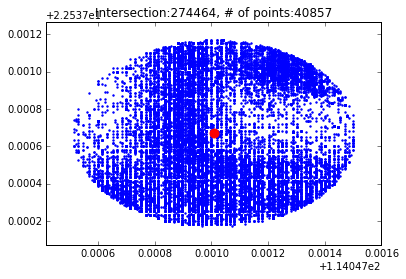

In [2]:
#329946
center,points = readJR(LEAST=30000)
plotJR(center,points)
(center[0],center[2],center[1]),(points[3].min(),points[2].min(),points[3].max(),points[2].max())

In [3]:
points.sort_values(by=[1])

,0,1,2,3
16276,36893,00:00:04,114.048302,22.537399
1484,23976,00:00:04,114.047981,22.537333
8068,30687,00:00:14,114.047783,22.537283
4492,26771,00:00:15,114.047836,22.537367
1947,24559,00:00:21,114.048264,22.537367
32741,36893,00:00:34,114.047997,22.537500
37080,63388,00:00:50,114.048302,22.537914
12121,34501,00:00:50,114.048103,22.537216
38755,63616,00:00:55,114.048393,22.537951
5227,27283,00:01:06,114.047920,22.537434


In [4]:
with open("./data/intersections","rb") as f:
    res=[]
    for i in f:
        res.append(i.strip().split(","))
df = pd.DataFrame(res)
df[0],df[1],df[2] = df[0].astype(int),df[1].astype(float),df[2].astype(float)

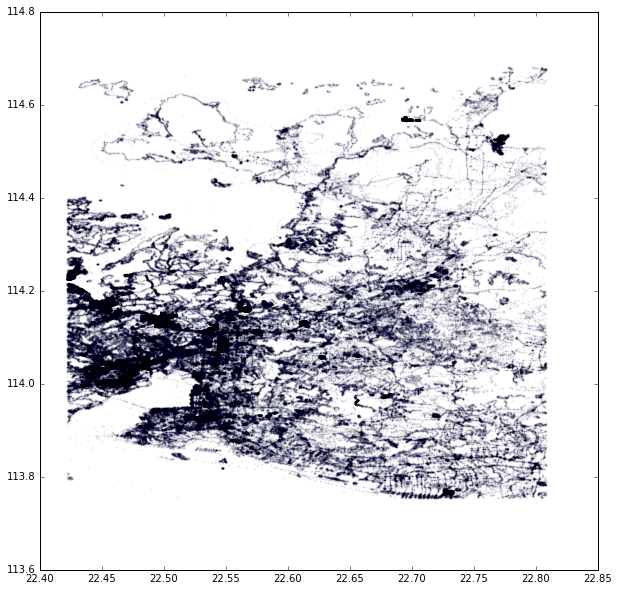

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(df[2],df[1],s=1,alpha=0.05)